# Coding 1 Home Assignment 1
### Authors: Mátyás Kovács & Márton Nagy

Let's import the necessary packages for the analysis.

In [64]:
import pandas as pd
import math
import numpy as np
from plotnine import *
import patchworklib as pw
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import display
from mizani.formatters import percent_format
import copy
from typing import List
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

First, we read the source datafile that was uploaded to Moodle.

In [4]:
raw = pd.read_csv('used-cars.csv')
raw.head()

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.6236,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.3702,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,NaN,gas,3.5721,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.3152,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.7000,red,...,0,850,6.745236,1993,25,2.928523,0,0,0,0


Next, we check the info on the raw data. We can see that while there are some missing values in certain variables, our variables of interest are complete.

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pricestr      549 non-null    object 
 1   area          549 non-null    object 
 2   subarea       540 non-null    object 
 3   name          549 non-null    object 
 4   condition     327 non-null    object 
 5   cylinders     360 non-null    object 
 6   drive         294 non-null    object 
 7   fuel          548 non-null    object 
 8   odometer      549 non-null    float64
 9   paintcolor    316 non-null    object 
 10  size          193 non-null    object 
 11  transmission  549 non-null    object 
 12  type          301 non-null    object 
 13  dealer        549 non-null    int64  
 14  price         549 non-null    int64  
 15  lnprice       549 non-null    float64
 16  year          549 non-null    int64  
 17  age           549 non-null    int64  
 18  lnodometer    549 non-null    

Just in case, we drop duplicate values (but actually, there are none).

In [8]:
raw.drop_duplicates(inplace=True)

We can now narrow down the dataframe to our variables of interest only, and then look at some summary statistics.

In [12]:
raw = raw.filter(['name', 'area', 'price', 'age'])
raw.describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,549.00,5866.15,5657.67,1.00,950.00,2400.00,4300.00,8299.00,14990.60,90002.00
age,549.00,12.18,5.89,1.00,3.00,8.00,12.00,16.00,21.00,27.00


We can see that price is in USD units. For better interpretation of the regression results later, we opt for converting it to thousands.

In [14]:
raw['price'] = raw['price'] / 1000

First, let's plot the distributions for the whole sample.

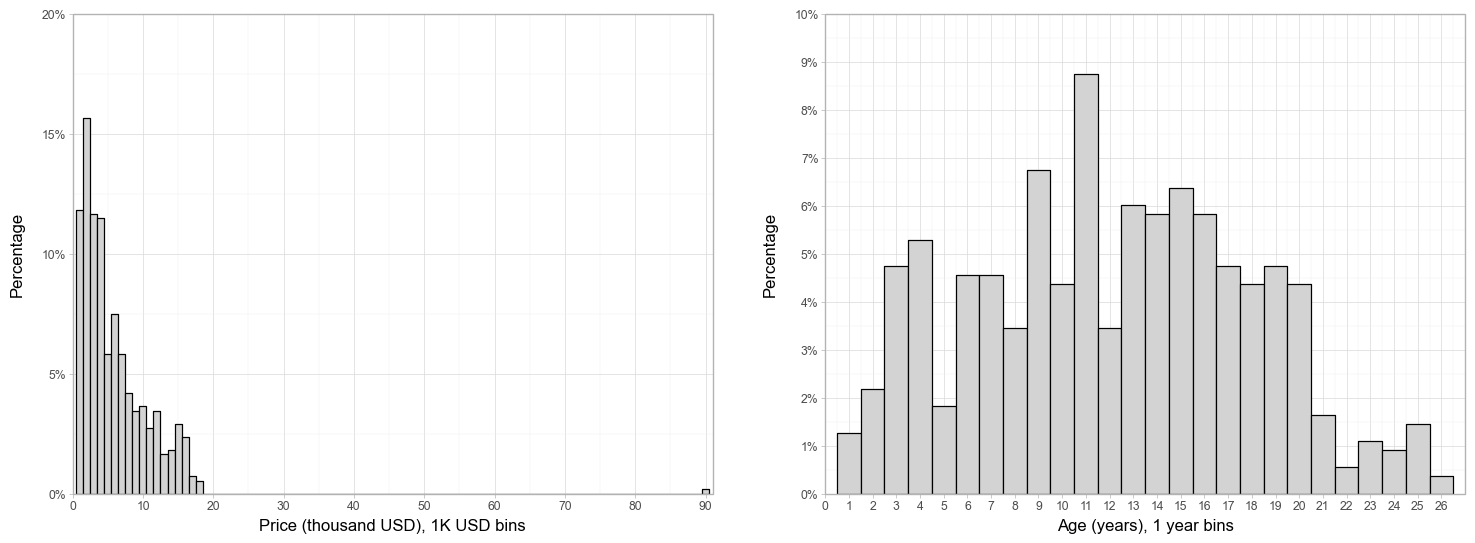

In [16]:
pw.basefigure.clear()
p1 = (
    ggplot(raw)
    + aes(x = 'price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 91),
        breaks=range(0, 91,10)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.2),
        breaks=np.arange(0,0.21,0.05),
        labels=percent_format()
    )
    + labs(
        x = 'Price (thousand USD), 1K USD bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(raw)
    + aes(x = 'age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 27),
        breaks=range(0, 27, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Age (years), 1 year bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

We shall also take a look at the log transformed distributions and summary statistics.

In [17]:
raw['ln_price'] = np.log(raw['price'])
raw['ln_age'] = np.log(raw['age'])

In [20]:
raw[['ln_price','ln_age']].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
ln_price,549.00,1.39,1.02,-6.91,-0.05,0.88,1.46,2.12,2.71,4.50
ln_age,549.00,2.34,0.65,0.00,1.10,2.08,2.48,2.77,3.04,3.30


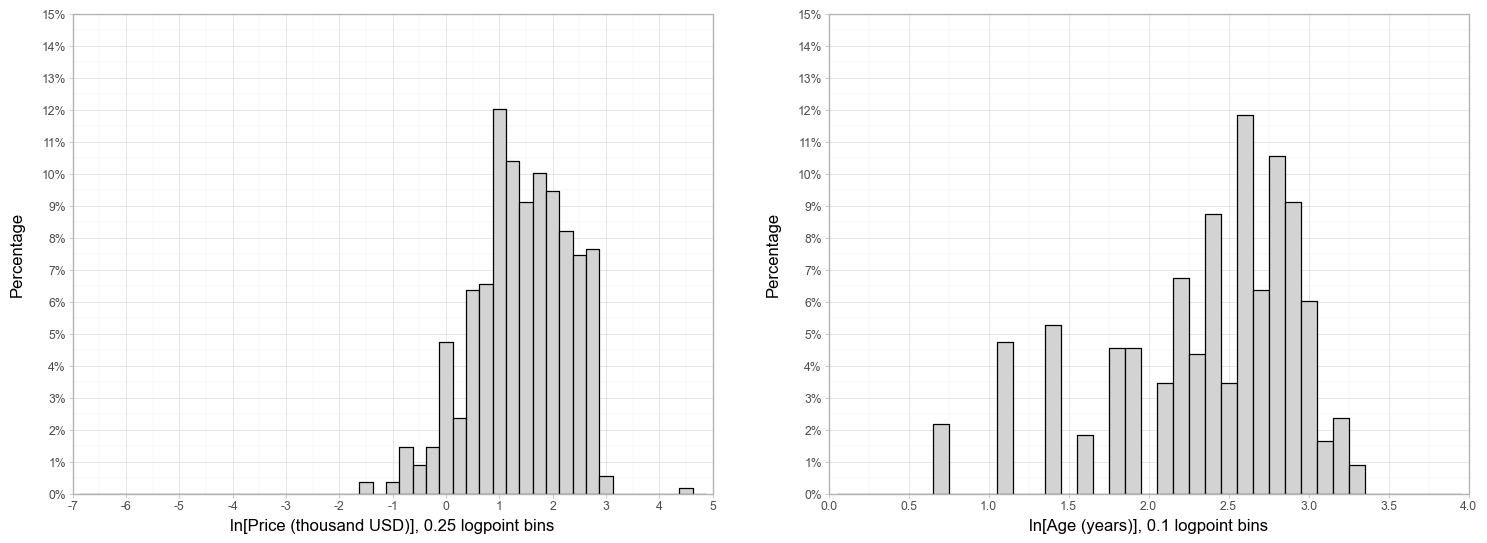

In [22]:
pw.basefigure.clear()
p1 = (
    ggplot(raw)
    + aes(x = 'ln_price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.25
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-7, 5),
        breaks=np.arange(-7, 5.1, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Price (thousand USD)], 0.25 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(raw)
    + aes(x = 'ln_age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 4),
        breaks=np.arange(0, 4.1, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Age (years)], 0.1 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

Next, we can create subsamples for the markets of the two cities in our dataset.

In [548]:
raw.area.unique()

array(['chicago', 'los angeles'], dtype=object)

In [560]:
#raw = raw.sort_values('age')
chicago = raw[raw['area'] == 'chicago']
la = raw[raw['area'] == 'los angeles']

We should also look at the summary statistics and distribution plots for the Chicago sample.

In [562]:
chicago.describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,327.00,5.96,4.52,0.21,0.88,2.30,4.40,8.97,14.99,18.50
age,327.00,12.19,5.98,1.00,3.00,7.00,12.00,17.00,21.00,27.00
ln_price,327.00,1.45,0.88,-1.58,-0.13,0.83,1.48,2.19,2.71,2.92
ln_age,327.00,2.33,0.65,0.00,1.10,1.95,2.48,2.83,3.04,3.30


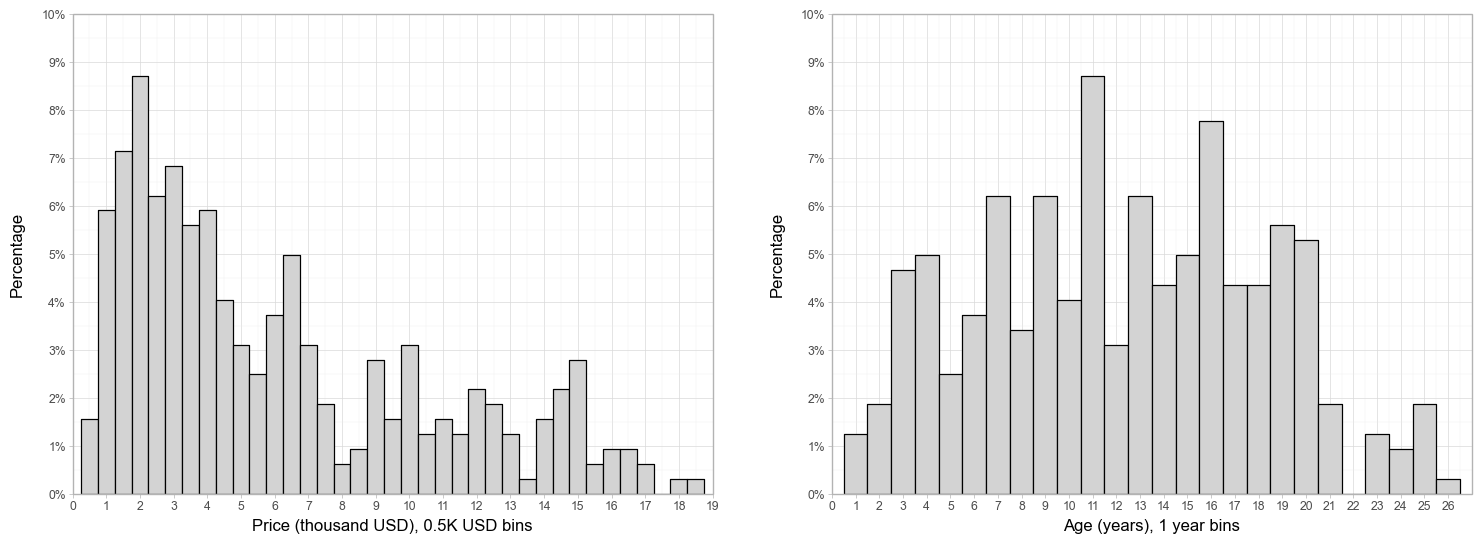

In [460]:
pw.basefigure.clear()
p1 = (
    ggplot(chicago)
    + aes(x = 'price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.5
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 19),
        breaks=range(0, 20,1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Price (thousand USD), 0.5K USD bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(chicago)
    + aes(x = 'age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 27),
        breaks=range(0, 27, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Age (years), 1 year bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

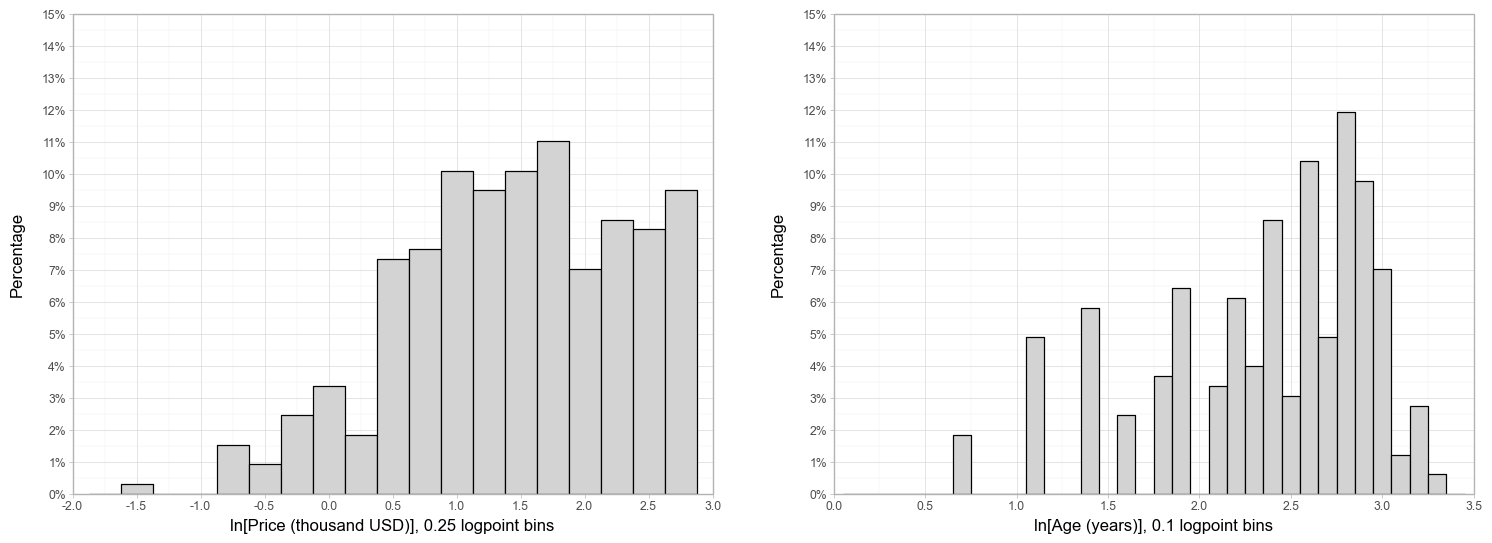

In [30]:
pw.basefigure.clear()
p1 = (
    ggplot(chicago)
    + aes(x = 'ln_price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.25
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-2, 3),
        breaks=np.arange(-2, 3.1, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Price (thousand USD)], 0.25 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(chicago)
    + aes(x = 'ln_age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 3.5),
        breaks=np.arange(0, 3.51, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Age (years)], 0.1 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

From the above distributions, but more importantly from the below scatterplot, we can see that there are a small number of observations that do not fit into the pattern at all, in the lower left corner. These would be quite influential observations, so we shall exclude these observations from the analysis.

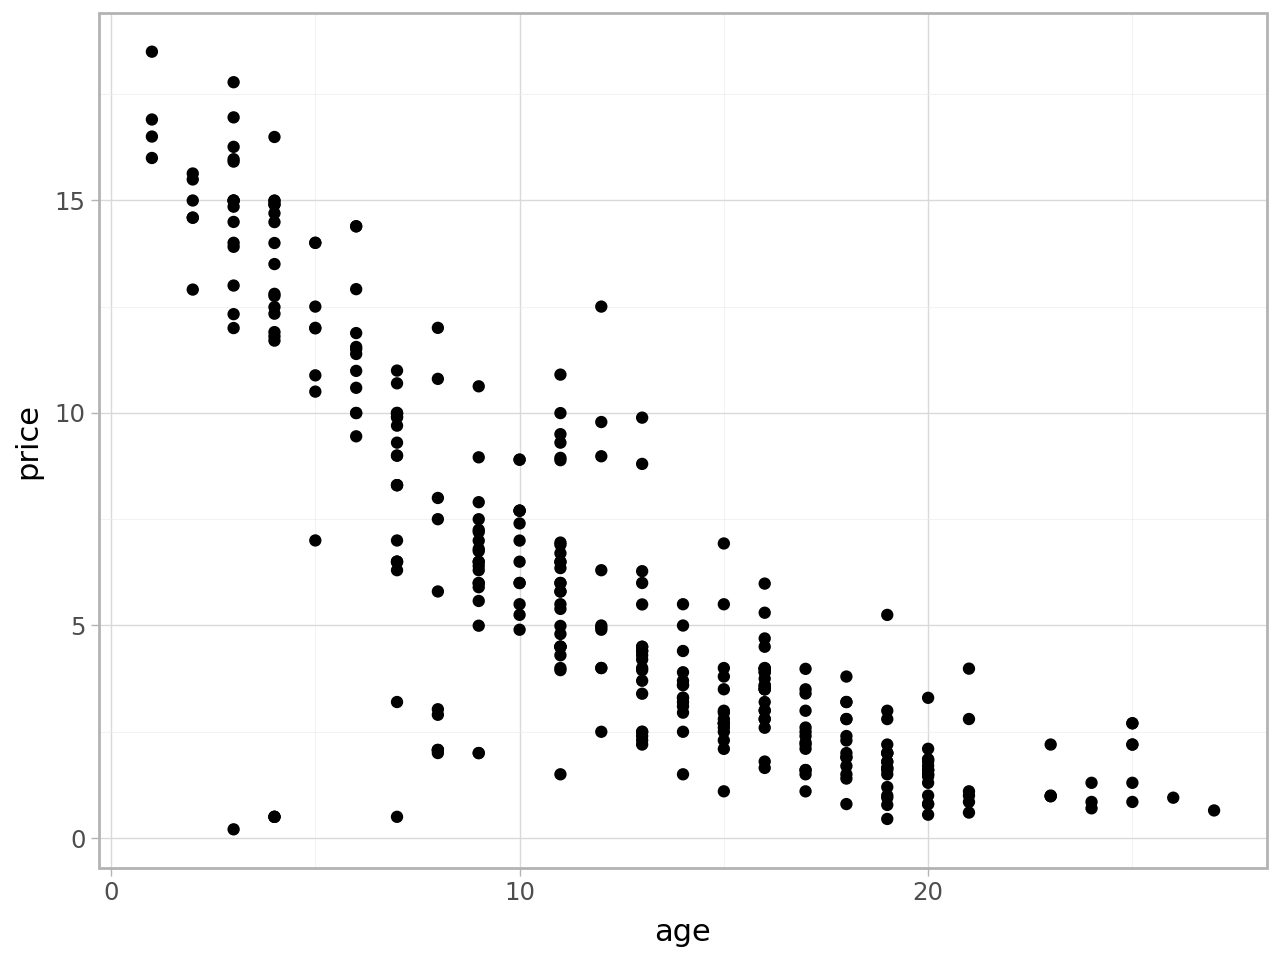

In [564]:
(
    ggplot(chicago)
    + aes(x = 'age', y = 'price')
    + geom_point()
    + theme_light()
)

In [567]:
chicago = (chicago[
           ~((chicago['age'] < 10)
           & (chicago['price'] < 1))
           ]
          )

Now we can plot some lowess estimates in all possible log-transformation specification.

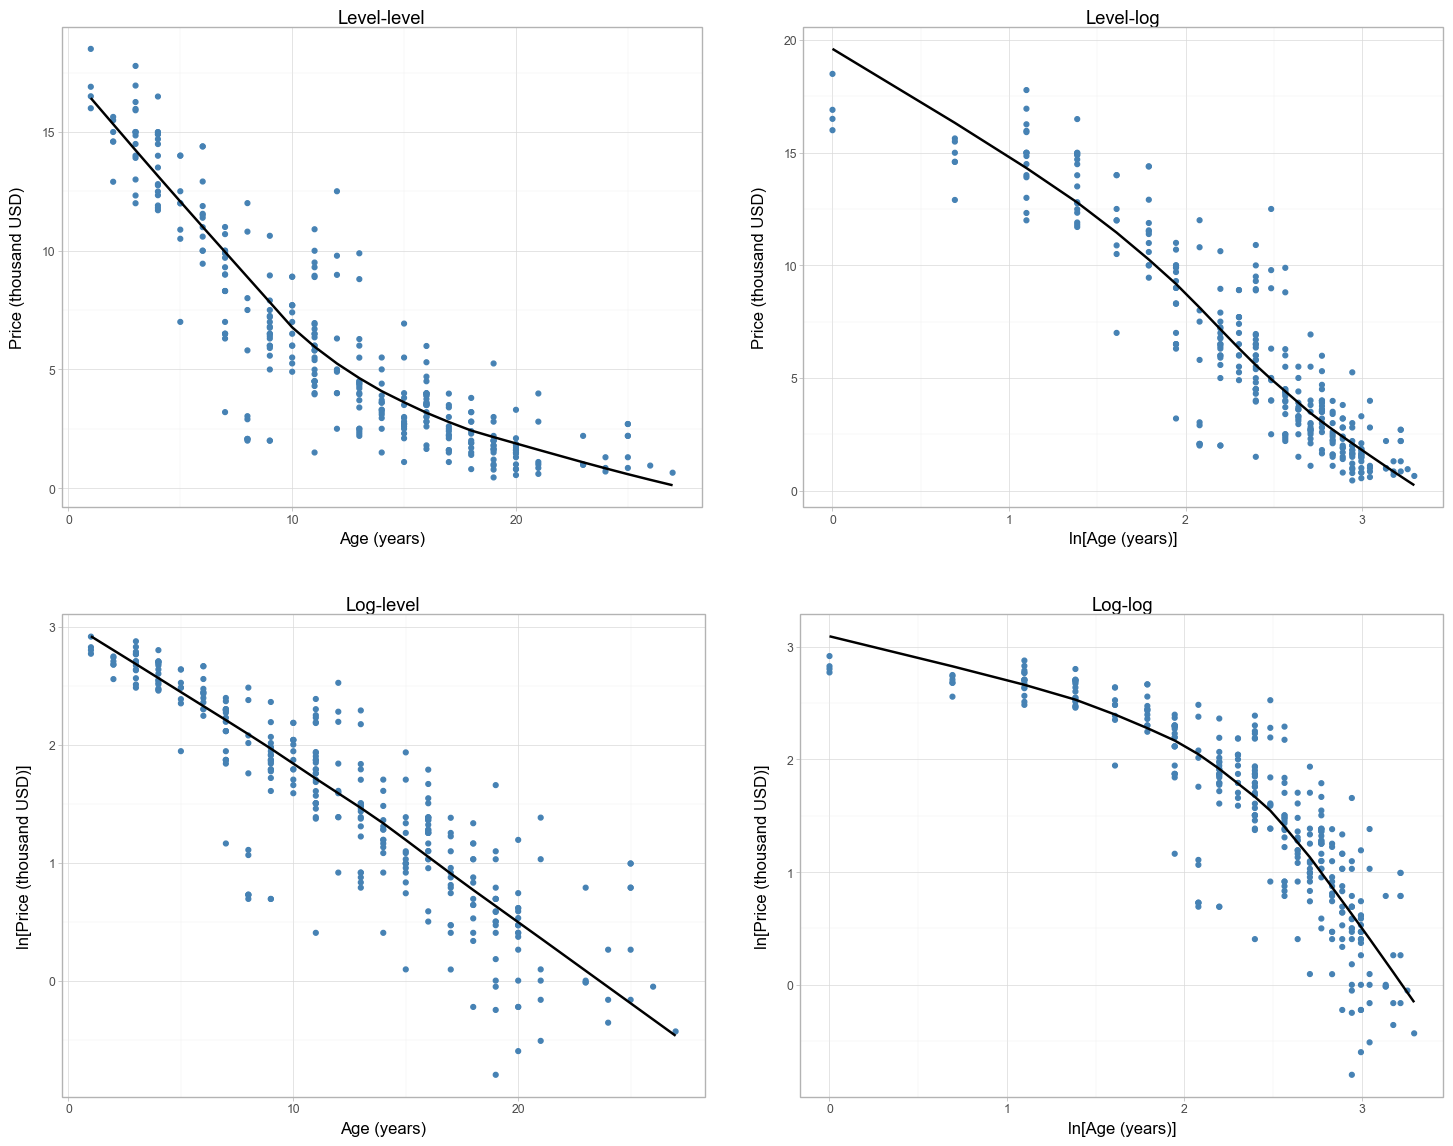

In [570]:
pw.basefigure.clear()
p1 = (
    ggplot(chicago)
    + aes(x = 'age', y = 'price')
    + geom_point(color = 'steelblue')
    + geom_smooth(method = 'lowess')
    + theme_light()
    + labs(
        x = 'Age (years)',
        y = 'Price (thousand USD)',
        title = 'Level-level'
    )
)

p2 = (
    ggplot(chicago)
    + aes(x = 'ln_age', y = 'price')
    + geom_point(color = 'steelblue')
    + geom_smooth(method = 'lowess')
    + theme_light()
    + labs(
        x = 'ln[Age (years)]',
        y = 'Price (thousand USD)',
        title = 'Level-log'
    )
)

p3 = (
    ggplot(chicago)
    + aes(x = 'age', y = 'ln_price')
    + geom_point(color = 'steelblue')
    + geom_smooth(method = 'lowess')
    + theme_light()
    + labs(
        x = 'Age (years)',
        y = 'ln[Price (thousand USD)]',
        title = 'Log-level'
    )
)

p4 = (
    ggplot(chicago)
    + aes(x = 'ln_age', y = 'ln_price')
    + geom_point(color = 'steelblue')
    + geom_smooth(method = 'lowess')
    + theme_light()
    + labs(
        x = 'ln[Age (years)]',
        y = 'ln[Price (thousand USD)]',
        title = 'Log-log'
    )
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)
p4 = pw.load_ggplot(p4)

combined = (p1|p2)/(p3|p4)
combined.savefig()

We use the same linear spline functions as used in class.

In [66]:
def knot_ceil(vector: np.array, knot: float) -> np.array:
    """
    Apply a ceiling value to elements in a numpy array.

    This function takes a numpy array and a ceiling value (knot). It returns a copy of the array where all elements greater than the ceiling value are replaced by the ceiling value.

    Parameters:
    vector (np.array): The input numpy array.
    knot (float): The ceiling value to apply.

    Returns:
    np.array: A new numpy array with elements capped at the ceiling value.
    
    Example:
    >>> import numpy as np
    >>> vector = np.array([1, 2, 3, 4, 5])
    >>> knot = 3
    >>> knot_ceil(vector, knot)
    array([1, 2, 3, 3, 3])
    """
    
    vector_copy = copy.deepcopy(vector)
    # vector_copy = vector.copy()
    vector_copy[vector_copy > knot] = knot
    return vector_copy


def lspline(series: pd.Series, knots: List[float]) -> np.array:
    """
    Generate a linear spline basis matrix for a given pandas Series and knots.

    This function creates a design matrix for linear splines based on the provided knots. 
    It iteratively applies a ceiling function to the series values at each knot, 
    subtracting the resulting column from the series to prepare for the next knot.

    Parameters:
    series (pd.Series): The input pandas Series.
    knots (List[float]): A list of knot values where the spline should change slope.

    Returns:
    np.array: A design matrix where each column corresponds to a segment of the linear spline.

    Example:
    >>> import pandas as pd
    >>> series = pd.Series([1, 2, 3, 4, 5])
    >>> knots = [2, 4]
    >>> lspline(series, knots)
    array([[1, 0, 0],
           [2, 0, 0],
           [2, 1, 0],
           [2, 2, 0],
           [2, 2, 1]])
    """
    
    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])

        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))

        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))

    return design_matrix

Next, we calculate 12 regressions, 4 simple linear, 4 quadratic and 4 PLS ones. Each type of regression is estimated in all possible log-transformation specification. PLS models are estimated with knots at 10 and 15 years, a choice based on the lowess estimates. We use robust standard errors (HC0).

In [575]:
regs = []
chicago['age_sq'] = np.power(chicago['age'],2)
chicago['ln_age_sq'] = np.power(chicago['ln_age'],2)
regs.append(smf.ols(formula='price~age',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~ln_age',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~age',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~ln_age',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~age+age_sq',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~ln_age+ln_age_sq',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~age+age_sq',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~ln_age+ln_age_sq',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~lspline(age,[10,15])',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~lspline(ln_age,[np.log(10),np.log(15)])',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~lspline(age,[10,15])',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~lspline(ln_age,[np.log(10),np.log(15)])',data=chicago).fit(cov_type = 'HC0'))

In [582]:
#WE STILL NEED TO RENAME THE COVARIATES AND ADD NOTE ON ROBUST SE.

In [577]:
table = Stargazer(regs)
table.custom_columns(['Level-level','Level-log','Log-level','Log-log',
                      'Level-level Quadratic','Level-log Quadratic','Log-level Quadratic','Log-log Quadratic',
                      'Level-level PLS','Level-log PLS','Log-level PLS', 'Log-log PLS'
                     ])
table

We extract the predicted values from the regressions, and transform it back to level price if needed. We also add a lowess estimate.

In [534]:
columns = ['Level-level','Level-log','Log-level','Log-log',
           'Level-level Quadratic','Level-log Quadratic','Log-level Quadratic','Log-log Quadratic',
           'Level-level PLS','Level-log PLS','Log-level PLS', 'Log-log PLS'
          ]
pred_dict = {}
pred_dict['age'] = list(chicago['age'])
i = 0
for reg in regs:
    if 'Log-' in columns[i]:
        residual_variance = np.var(list(reg.resid))
        pred_dict[columns[i]] = [np.exp(x)*np.exp(residual_variance/2) for x in list(reg.get_prediction().summary_frame()['mean'])]
    else:
        pred_dict[columns[i]] = list(reg.get_prediction().summary_frame()['mean'])
    i += 1
    
pred_df = pd.DataFrame(pred_dict)
pred_df['Lowess'] = list(sm.nonparametric.lowess(chicago['price'], chicago['age'], frac=0.66, return_sorted=False))

In [446]:
pred_df

,age,Level-level,Level-log,Log-level,Log-log,Level-level Quadratic,Level-log Quadratic,Log-level Quadratic,Log-log Quadratic,Level-level PLS,Level-log PLS,Log-level PLS,Log-log PLS,Lowess
0,1,13.452485,20.928784,19.354559,60.944670,16.849228,18.834795,20.573796,14.534875,16.613676,20.267554,19.576003,28.236721,16.666543
1,1,13.452485,20.928784,19.354559,60.944670,16.849228,18.834795,20.573796,14.534875,16.613676,20.267554,19.576003,28.236721,16.666543
2,1,13.452485,20.928784,19.354559,60.944670,16.849228,18.834795,20.573796,14.534875,16.613676,20.267554,19.576003,28.236721,16.666543
3,1,13.452485,20.928784,19.354559,60.944670,16.849228,18.834795,20.573796,14.534875,16.613676,20.267554,19.576003,28.236721,16.666543
4,2,12.798075,16.536426,17.117146,29.081445,15.431589,15.868381,17.946197,18.040514,15.420650,16.199239,17.292042,18.599441,15.513846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,25,-2.253348,0.531304,1.014698,1.962335,1.863469,-0.116384,1.092746,1.234051,0.722208,0.873262,1.051247,1.100607,0.721141
318,25,-2.253348,0.531304,1.014698,1.962335,1.863469,-0.116384,1.092746,1.234051,0.722208,0.873262,1.051247,1.100607,0.721141
319,25,-2.253348,0.531304,1.014698,1.962335,1.863469,-0.116384,1.092746,1.234051,0.722208,0.873262,1.051247,1.100607,0.721141
320,26,-2.907758,0.282769,0.897398,1.881879,2.101271,-0.428644,0.982132,1.133961,0.458466,0.683837,0.934804,1.006698,0.507403


We can now plot the estimated prices from the regressions. For better visibility, we plot separate charts for each model type.

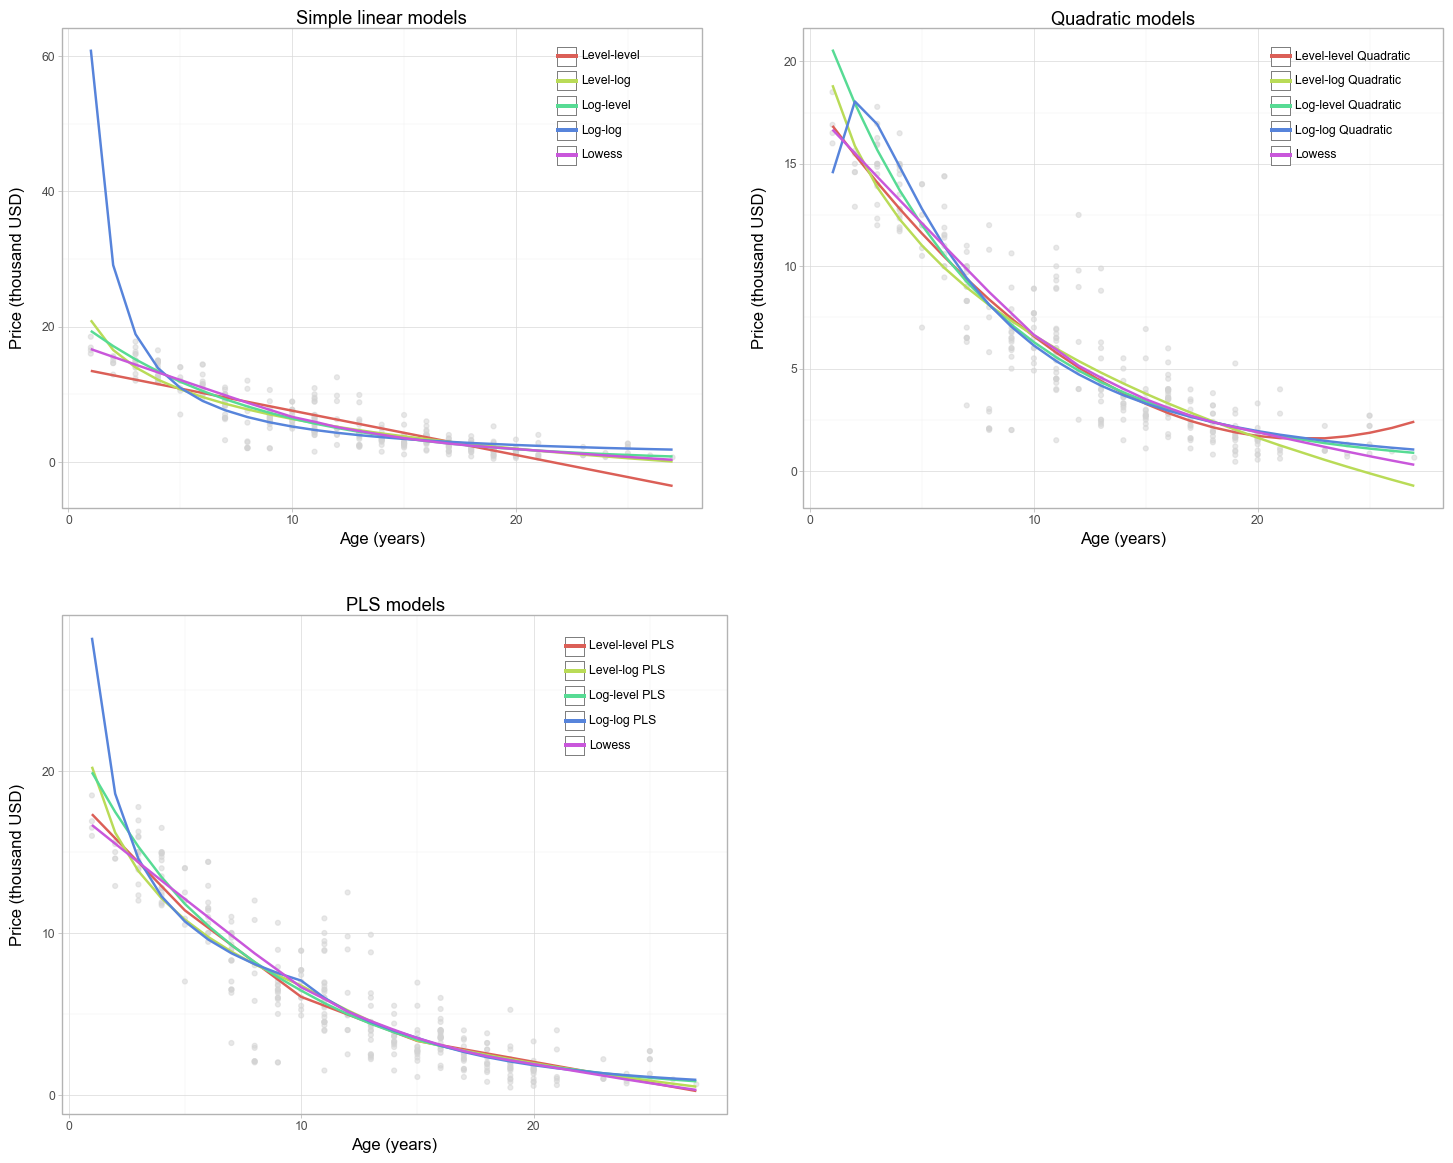

In [544]:
pw.basefigure.clear()
p1 = (
    ggplot(pred_df.melt(id_vars='age').query("~variable.str.contains('PLS|Quadratic')"))
    + aes(x = 'age', y = 'value', color = 'variable')
    + geom_point(
        aes(x = 'age', y = 'price'),
        data = chicago,
        color = 'lightgrey',
        alpha = 0.5
    )
    + geom_line(size = 1)
    + theme_light()
    + theme(
        legend_position=(0.85, 0.85),
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Simple linear models')
)

p2 = (
    ggplot(pred_df.melt(id_vars='age').query("variable.str.contains('Quadratic|Lowess')"))
    + aes(x = 'age', y = 'value', color = 'variable')
    + geom_point(
        aes(x = 'age', y = 'price'),
        data = chicago,
        color = 'lightgrey',
        alpha = 0.5
    )
    + geom_line(size = 1)
    + theme_light()
    + theme(
        legend_position=(0.85, 0.85),
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Quadratic models')
)

p3 = (
    ggplot(pred_df.melt(id_vars='age').query("variable.str.contains('PLS|Lowess')"))
    + aes(x = 'age', y = 'value', color = 'variable')
    + geom_point(
        aes(x = 'age', y = 'price'),
        data = chicago,
        color = 'lightgrey',
        alpha = 0.5
    )
    + geom_line(size = 1)
    + theme_light()
    + theme(
        legend_position=(0.85, 0.85),
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'PLS models')
)

p4 = ggplot(chicago)+theme_void()

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)
p4 = pw.load_ggplot(p4)

combined = (p1|p2)/(p3|p4)
combined.savefig()

We can also plot the best fitting two models only, along with the lowess estimate.

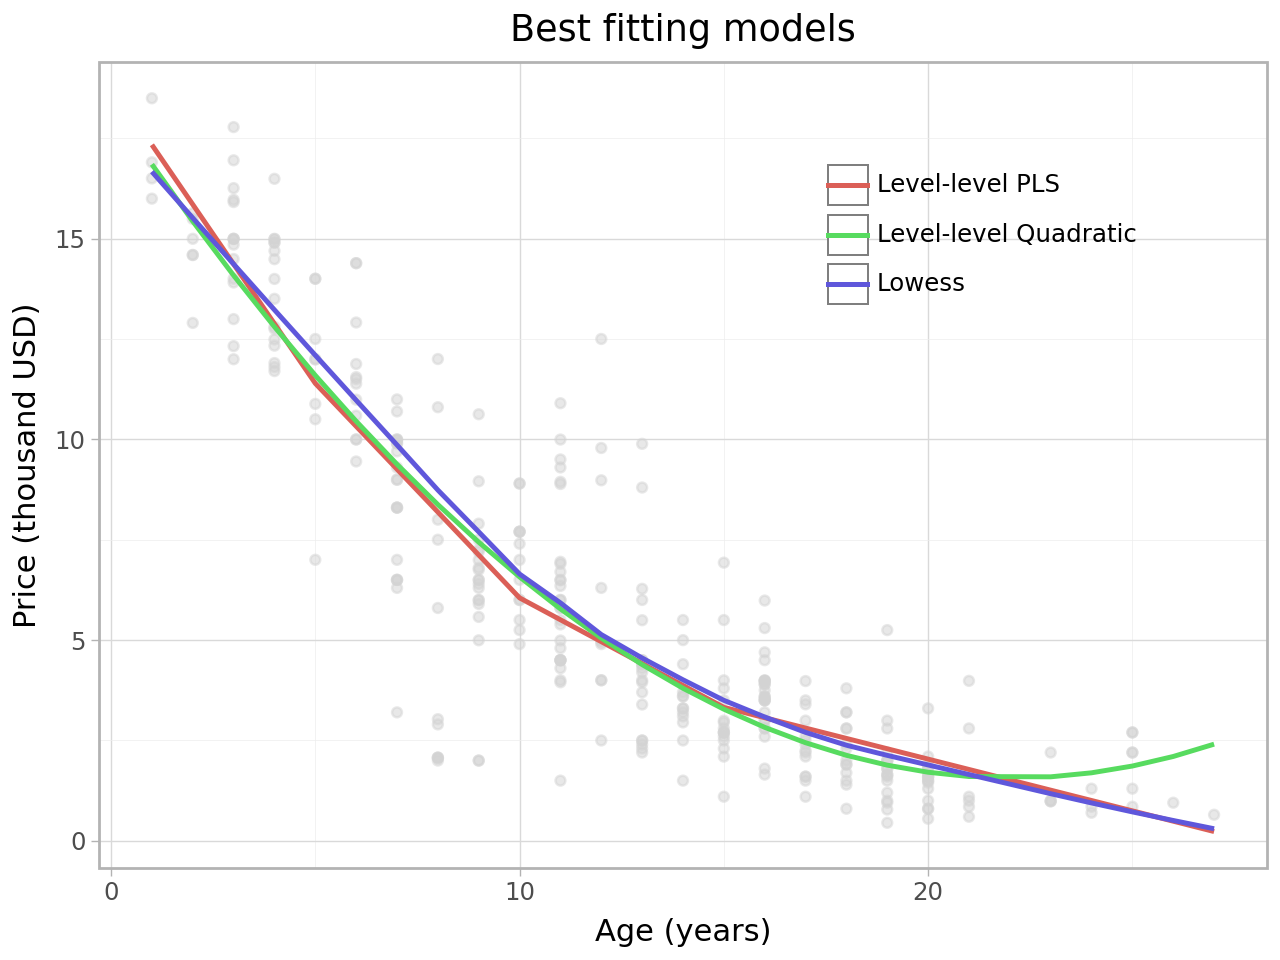

In [536]:
(
    ggplot(pred_df.melt(id_vars='age').query("variable.str.contains('Level-level PLS|Level-level Quadratic|Lowess')"))
    + aes(x = 'age', y = 'value', color = 'variable')
    + geom_point(
        aes(x = 'age', y = 'price'),
        data = chicago,
        color = 'lightgrey',
        alpha = 0.5
    )
    + geom_line(size = 1)
    + theme_light()
    + theme(
        legend_position=(0.85, 0.85),
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Best fitting models')
)